***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)
df_html.head()

Shape of our dataset: (43491, 1433)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_ftp,a_href_https,a_href_irc,a_href_mailto,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,a_rel_designer,a_rel_detalis,a_rel_discussion,a_rel_dofollow,...,object_data_.svg,object_data_.swf,object_data_absolute,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,pro

In [6]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)


df_js.drop(['js_function_Object.defineProperty(',
'js_function_Object.keys(',
'js_function_.substr',
'js_function_unescape('],axis=1,inplace=True)
print("Shape of our dataset:",df_js.shape)
df_js.head()

Shape of our dataset: (43294, 397)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [7]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)

### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)
df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

num_stats_js=num_stats(df_js,num_var_js)
cat_stats_js=cat_stats(df_js,cat_var_js)


num_stats_html=num_stats(df_html,num_var_html)
cat_stats_html=cat_stats(df_html,cat_var_html)

fin_col=num_stats_js.index.values[0:25].tolist()+cat_stats_js.index.values[0:25].tolist() + num_stats_html.index.values[0:25].tolist()+cat_stats_html.index.values[0:25].tolist() 

In [8]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 51)

In [9]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [10]:
fin_col

['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'dom_function_document.getElementById(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [11]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [12]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.872508981484
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27669   169    27838
True        3983   746     4729
__all__    31652   915    32567

Accuracy of the model for test data is: 0.865020879391
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6881    59     6940
True        1040   162     1202
__all__     7921   221     8142



Logistic Regression
Accuracy of the model for training data is: 0.875303221052
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24764  3074    27838
True         987  3742     4729
__all__    25751  6816    32567

Accuracy of the model for test data is: 0.877548513879
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6171   769     6940
True         228   974     1202
__all__     6399  1743     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.909141155157
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25007  2831    27838
True         128  4601     4729
__all__    25135  7432    32567

Accuracy of the model for test data is: 0.89695406534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6216   724     6940
True         115  1087     1202
__all__     6331  1811     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.876930635306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24651  3187    27838
True         821  3908     4729
__all__    25472  7095    32567

Accuracy of the model for test data is: 0.876934414149
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6143   797     6940
True         205   997     1202
__all__     6348  1794     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.893573248994
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24952  2886    27838
True         580  4149     4729
__all__    25532  7035    32567

Accuracy of the model for test data is: 0.891058707934
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6209   731     6940
True         156  1046     1202
__all__     6365  1777     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.911167746492
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25014  2824    27838
True          69  4660     4729
__all__    25083  7484    32567

Accuracy of the model for test data is: 0.897813804962
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6220   720     6940
True         112  1090     1202
__all__     6332  1810     8142



Bagging Classifier
Accuracy of the model for training data is: 0.909049037369
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25006  2832    27838
True         130  4599     4729
__all__    25136  7431    32567

Accuracy of the model for test data is: 0.896217145664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6206   734     6940
True         111  1091     1202
__all__     6317  1825     8142



Neural Network-1
The accuracy of the model on training data is: 0.895569134409


Predicted  False  True  __all__
Actual                         
False      24648  3190    27838
True         211  4518     4729
__all__    24859  7708    32567

The accuracy of the model on test data is: 0.887251289609


Predicted  False  True  __all__
Actual                         
False       6125   815     6940
True         103  1099     1202
__all__     6228  1914     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [13]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [14]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.872509,746.0,27669.0,169.0,3983.0,0.006071,0.842250
LogisticRegression,0.875303,3742.0,24764.0,3074.0,987.0,0.110425,0.208712
RandomForestClassifier,0.909141,4601.0,25007.0,2831.0,128.0,0.101696,0.027067
AdaBoostClassifier,0.876931,3908.0,24651.0,3187.0,821.0,0.114484,0.173610
GradientBoostingClassifier,0.893573,4149.0,24952.0,2886.0,580.0,0.103671,0.122647
ExtraTreeClassifier,0.911168,4660.0,25014.0,2824.0,69.0,0.101444,0.014591
BaggingClassifier,0.909049,4599.0,25006.0,2832.0,130.0,0.101731,0.027490
Neural Network-1,0.895569,4518.0,24648.0,3190.0,211.0,0.114592,0.044618


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.865021,162.0,6881.0,59.0,1040.0,0.008501,0.865225,0.563137,0.275651
LogisticRegression,0.877549,974.0,6171.0,769.0,228.0,0.110807,0.189684,0.849755,0.604952
RandomForestClassifier,0.896954,1087.0,6216.0,724.0,115.0,0.104323,0.095674,0.900002,0.682383
AdaBoostClassifier,0.876934,997.0,6143.0,797.0,205.0,0.114841,0.170549,0.857305,0.611605
GradientBoostingClassifier,0.891059,1046.0,6209.0,731.0,156.0,0.105331,0.129784,0.882442,0.656879
ExtraTreeClassifier,0.897814,1090.0,6220.0,720.0,112.0,0.103746,0.093178,0.901538,0.685139
BaggingClassifier,0.896217,1091.0,6206.0,734.0,111.0,0.105764,0.092346,0.900945,0.682119
Neural Network-1,0.887251,1099.0,6125.0,815.0,103.0,0.117435,0.085691,0.900945,0.666617


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [15]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [16]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [17]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [18]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.599109131403
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27096   742    27838
True       21578  6260    27838
__all__    48674  7002    55676

Accuracy of the model for test data is: 0.845369688037
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6690   250     6940
True        1009   193     1202
__all__     7699   443     8142



Logistic Regression
Accuracy of the model for training data is: 0.885875422085
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22517   5321    27838
True        1033  26805    27838
__all__    23550  32126    55676

Accuracy of the model for test data is: 0.83099975436
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5618  1322     6940
True          54  1148     1202
__all__     5672  2470     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.946458078885
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24916   2922    27838
True          59  27779    27838
__all__    24975  30701    55676

Accuracy of the model for test data is: 0.894988946205
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6180   760     6940
True          95  1107     1202
__all__     6275  1867     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.901950571162
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23567   4271    27838
True        1188  26650    27838
__all__    24755  30921    55676

Accuracy of the model for test data is: 0.860599361336
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5883  1057     6940
True          78  1124     1202
__all__     5961  2181     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.922102880954
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24190   3648    27838
True         689  27149    27838
__all__    24879  30797    55676

Accuracy of the model for test data is: 0.877794153771
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6026   914     6940
True          81  1121     1202
__all__     6107  2035     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.94710467706
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24924   2914    27838
True          31  27807    27838
__all__    24955  30721    55676

Accuracy of the model for test data is: 0.89695406534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6196   744     6940
True          95  1107     1202
__all__     6291  1851     8142



Bagging Classifier
Accuracy of the model for training data is: 0.946296429341
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24913   2925    27838
True          65  27773    27838
__all__    24978  30698    55676

Accuracy of the model for test data is: 0.894988946205
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6168   772     6940
True          83  1119     1202
__all__     6251  1891     8142



Neural Network-1
The accuracy of the model on training data is: 0.934819311732


Predicted  False   True  __all__
Actual                          
False      24290   3548    27838
True          81  27757    27838
__all__    24371  31305    55676

The accuracy of the model on test data is: 0.875460574797


Predicted  False  True  __all__
Actual                         
False       5998   942     6940
True          72  1130     1202
__all__     6070  2072     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [19]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [20]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.599109,6260.0,27096.0,742.0,21578.0,0.026654,0.775128
LogisticRegression,0.885875,26805.0,22517.0,5321.0,1033.0,0.191142,0.037108
RandomForestClassifier,0.946458,27779.0,24916.0,2922.0,59.0,0.104964,0.002119
AdaBoostClassifier,0.901951,26650.0,23567.0,4271.0,1188.0,0.153423,0.042675
GradientBoostingClassifier,0.922103,27149.0,24190.0,3648.0,689.0,0.131044,0.024750
ExtraTreeClassifier,0.947105,27807.0,24924.0,2914.0,31.0,0.104677,0.001114
BaggingClassifier,0.946296,27773.0,24913.0,2925.0,65.0,0.105072,0.002335
Neural Network-1,0.934819,27757.0,24290.0,3548.0,81.0,0.127452,0.002910


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.845370,193.0,6690.0,250.0,1009.0,0.036023,0.839434,0.562271,0.194774
LogisticRegression,0.831000,1148.0,5618.0,1322.0,54.0,0.190490,0.044925,0.882292,0.589985
RandomForestClassifier,0.894989,1107.0,6180.0,760.0,95.0,0.109510,0.079035,0.905727,0.684727
AdaBoostClassifier,0.860599,1124.0,5883.0,1057.0,78.0,0.152305,0.064892,0.891401,0.627042
GradientBoostingClassifier,0.877794,1121.0,6026.0,914.0,81.0,0.131700,0.067388,0.900456,0.656176
ExtraTreeClassifier,0.896954,1107.0,6196.0,744.0,95.0,0.107205,0.079035,0.906880,0.688756
BaggingClassifier,0.894989,1119.0,6168.0,772.0,83.0,0.111239,0.069052,0.909855,0.688607
Neural Network-1,0.875461,1130.0,5998.0,942.0,72.0,0.135735,0.059900,0.909855,0.655082


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [21]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [22]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9458, 50)


In [23]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.572108268133
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4592   137     4729
True        3910   819     4729
__all__     8502   956     9458

Accuracy of the model for test data is: 0.839105870793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6654   286     6940
True        1024   178     1202
__all__     7678   464     8142



Logistic Regression
Accuracy of the model for training data is: 0.878727003595
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3783   946     4729
True         201  4528     4729
__all__     3984  5474     9458

Accuracy of the model for test data is: 0.826086956522
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5580  1360     6940
True          56  1146     1202
__all__     5636  2506     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.941530979065
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4222   507     4729
True          46  4683     4729
__all__     4268  5190     9458

Accuracy of the model for test data is: 0.886268730042
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6099   841     6940
True          85  1117     1202
__all__     6184  1958     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.893529287376
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3964   765     4729
True         242  4487     4729
__all__     4206  5252     9458

Accuracy of the model for test data is: 0.858020142471
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5852  1088     6940
True          68  1134     1202
__all__     5920  2222     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.908437301755
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4076   653     4729
True         213  4516     4729
__all__     4289  5169     9458

Accuracy of the model for test data is: 0.869196757553
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5945   995     6940
True          70  1132     1202
__all__     6015  2127     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.945654472404
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4225   504     4729
True          10  4719     4729
__all__     4235  5223     9458

Accuracy of the model for test data is: 0.888847948907
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6118   822     6940
True          83  1119     1202
__all__     6201  1941     8142



Bagging Classifier
Accuracy of the model for training data is: 0.94258828505
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4224   505     4729
True          38  4691     4729
__all__     4262  5196     9458

Accuracy of the model for test data is: 0.881478752149
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6046   894     6940
True          71  1131     1202
__all__     6117  2025     8142



Neural Network-1
The accuracy of the model on training data is: 0.927786001281


Predicted  False  True  __all__
Actual                         
False       4073   656     4729
True          27  4702     4729
__all__     4100  5358     9458

The accuracy of the model on test data is: 0.856914762958


Predicted  False  True  __all__
Actual                         
False       5820  1120     6940
True          45  1157     1202
__all__     5865  2277     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.572108,819.0,4592.0,137.0,3910.0,0.028970,0.826813
LogisticRegression,0.878727,4528.0,3783.0,946.0,201.0,0.200042,0.042504
RandomForestClassifier,0.941531,4683.0,4222.0,507.0,46.0,0.107211,0.009727
AdaBoostClassifier,0.893529,4487.0,3964.0,765.0,242.0,0.161768,0.051174
GradientBoostingClassifier,0.908437,4516.0,4076.0,653.0,213.0,0.138084,0.045041
ExtraTreeClassifier,0.945654,4719.0,4225.0,504.0,10.0,0.106576,0.002115
BaggingClassifier,0.942588,4691.0,4224.0,505.0,38.0,0.106788,0.008036
Neural Network-1,0.927786,4702.0,4073.0,656.0,27.0,0.138719,0.005709


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.839106,178.0,6654.0,286.0,1024.0,0.041210,0.851913,0.553438,0.163542
LogisticRegression,0.826087,1146.0,5580.0,1360.0,56.0,0.195965,0.046589,0.878723,0.582113
RandomForestClassifier,0.886269,1117.0,6099.0,841.0,85.0,0.121182,0.070715,0.904051,0.670745
AdaBoostClassifier,0.858020,1134.0,5852.0,1088.0,68.0,0.156772,0.056572,0.893328,0.626446
GradientBoostingClassifier,0.869197,1132.0,5945.0,995.0,70.0,0.143372,0.058236,0.899196,0.644684
ExtraTreeClassifier,0.888848,1119.0,6118.0,822.0,83.0,0.118444,0.069052,0.906252,0.676416
BaggingClassifier,0.881479,1131.0,6046.0,894.0,71.0,0.128818,0.059068,0.906057,0.666449
Neural Network-1,0.856915,1157.0,5820.0,1120.0,45.0,0.161383,0.037438,0.906057,0.633208


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [28]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

Built 4950 features
EntitySet scattered to workers in 4.765 seconds
Elapsed: 00:31 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [29]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [30]:
def feat_transformation(data,feature):
    for i in range(0,len(feature)):
        for j in range(i,len(feature)):
            if feature[i]!=feature[j]:
                new_feat=str(feature[i])+"+"+str(feature[j])
                data[new_feat]=data[feature[i]]+data[feature[j]]
    
                new_feat=str(feature[i])+"*"+str(feature[j])
                data[new_feat]=data[feature[i]]*data[feature[j]]
             
                new_feat=str(feature[i])+"/"+str(feature[j])  
                data[new_feat]=data[feature[i]]/data[feature[j]]             

In [31]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [32]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [33]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [34]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [35]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [36]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 92)

In [37]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_src_out_of_domain / script_src_relative',
 'script_src_https / script_src_relative',
 'script_src_.js / script_src_relative',
 'script_src_.js / script_count',
 'script_src_.js + script_src_out_of_domain',
 'script_count + script_src_.js',
 'script_async_true / script_count',
 'link_rel_stylesheet + script_src_.js',
 'img_src_out_of_domain / img_src_absolute',
 'a_href_https / a_count',
 'script_type_text/javascript / script_count',
 'script_type_text/javascript / img_src_absolute',
 'script_src_relative / script_count',
 'script_src_relative / img_src_absolute',
 'script_src_out_of_domain / script_count',
 'script_src_https / script_count',
 'script_src_.js',
 'script_count + script_src_out_of_domain',
 'script_count',
 'meta_http-equiv_X-UA-Compatible / script_src_out_of_domain',
 'meta_http-equiv_X-UA-Compatible + script_src_.js',
 'link_rel_stylesheet / link_href_absolute',
 'link_rel_stylesheet / img_src_absolute',
 'link_rel_stylesheet + script_src_relative',
 'link_rel_

In [38]:
fs=fs.reindex(df_sel.index.values)

In [39]:
train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [40]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [41]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.871065802807
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27694   144    27838
True        4055   674     4729
__all__    31749   818    32567

Accuracy of the model for test data is: 0.863792679931
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6894    46     6940
True        1063   139     1202
__all__     7957   185     8142



Logistic Regression
Accuracy of the model for training data is: 0.881536524703
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24638  3200    27838
True         658  4071     4729
__all__    25296  7271    32567

Accuracy of the model for test data is: 0.883198231393
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6147   793     6940
True         158  1044     1202
__all__     6305  1837     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.906131974084
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24961  2877    27838
True         180  4549     4729
__all__    25141  7426    32567

Accuracy of the model for test data is: 0.895971505773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6211   729     6940
True         118  1084     1202
__all__     6329  1813     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.879233580004
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24460  3378    27838
True         555  4174     4729
__all__    25015  7552    32567

Accuracy of the model for test data is: 0.88025055269
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6099   841     6940
True         134  1068     1202
__all__     6233  1909     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.892375717751
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24884  2954    27838
True         551  4178     4729
__all__    25435  7132    32567

Accuracy of the model for test data is: 0.890935887988
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6206   734     6940
True         154  1048     1202
__all__     6360  1782     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.908281389136
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24970  2868    27838
True         119  4610     4729
__all__    25089  7478    32567

Accuracy of the model for test data is: 0.895603045935
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6212   728     6940
True         122  1080     1202
__all__     6334  1808     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9067767986
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24961  2877    27838
True         159  4570     4729
__all__    25120  7447    32567

Accuracy of the model for test data is: 0.894497666421
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6199   741     6940
True         118  1084     1202
__all__     6317  1825     8142



Neural Network-1
The accuracy of the model on training data is: 0.894156661668


Predicted  False  True  __all__
Actual                         
False      24569  3269    27838
True         178  4551     4729
__all__    24747  7820    32567

The accuracy of the model on test data is: 0.883812331123


Predicted  False  True  __all__
Actual                         
False       6105   835     6940
True         111  1091     1202
__all__     6216  1926     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [42]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [43]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871066,674.0,27694.0,144.0,4055.0,0.005173,0.857475
LogisticRegression,0.881537,4071.0,24638.0,3200.0,658.0,0.114951,0.139141
RandomForestClassifier,0.906132,4549.0,24961.0,2877.0,180.0,0.103348,0.038063
AdaBoostClassifier,0.879234,4174.0,24460.0,3378.0,555.0,0.121345,0.117361
GradientBoostingClassifier,0.892376,4178.0,24884.0,2954.0,551.0,0.106114,0.116515
ExtraTreeClassifier,0.908281,4610.0,24970.0,2868.0,119.0,0.103025,0.025164
BaggingClassifier,0.906777,4570.0,24961.0,2877.0,159.0,0.103348,0.033622
Neural Network-1,0.894157,4551.0,24569.0,3269.0,178.0,0.117429,0.037640


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.863793,139.0,6894.0,46.0,1063.0,0.006628,0.884359,0.554506,0.259506
LogisticRegression,0.883198,1044.0,6147.0,793.0,158.0,0.114265,0.131448,0.877144,0.640135
RandomForestClassifier,0.895972,1084.0,6211.0,729.0,118.0,0.105043,0.098170,0.898394,0.679372
AdaBoostClassifier,0.880251,1068.0,6099.0,841.0,134.0,0.121182,0.111481,0.883669,0.642491
GradientBoostingClassifier,0.890936,1048.0,6206.0,734.0,154.0,0.105764,0.128120,0.883058,0.657271
ExtraTreeClassifier,0.895603,1080.0,6212.0,728.0,122.0,0.104899,0.101498,0.896802,0.677325
BaggingClassifier,0.894498,1084.0,6199.0,741.0,118.0,0.106772,0.098170,0.897529,0.676307
Neural Network-1,0.883812,1091.0,6105.0,835.0,111.0,0.120317,0.092346,0.897529,0.657217


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [44]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [45]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

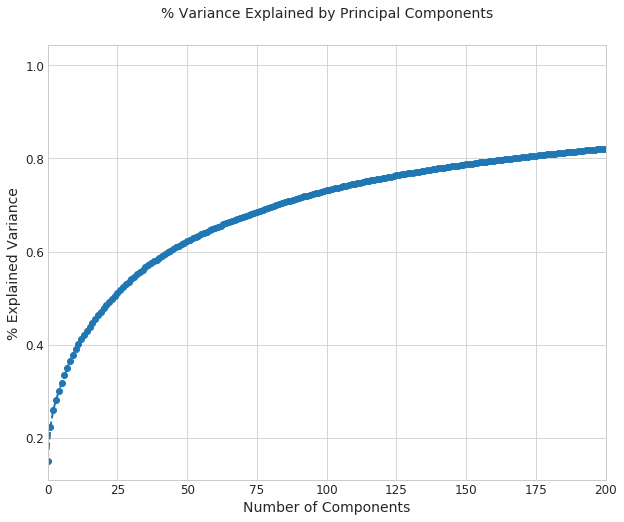

In [46]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [47]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0]

array([ 167,  168,  169, ..., 4947, 4948, 4949])

In [48]:
pca=PCA(n_components=167,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 167 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 167 components is: 0.799245227037


In [49]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [50]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,167).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.898455491755
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24925  2913    27838
True         394  4335     4729
__all__    25319  7248    32567

Accuracy of the model for test data is: 0.89302382707
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6188   752     6940
True         119  1083     1202
__all__     6307  1835     8142



Logistic Regression
Accuracy of the model for training data is: 0.883378880462
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24689  3149    27838
True         649  4080     4729
__all__    25338  7229    32567

Accuracy of the model for test data is: 0.884549250798
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6157   783     6940
True         157  1045     1202
__all__     6314  1828     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.908588448429
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25008  2830    27838
True         147  4582     4729
__all__    25155  7412    32567

Accuracy of the model for test data is: 0.896708425448
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6219   721     6940
True         120  1082     1202
__all__     6339  1803     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.887923358
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24875  2963    27838
True         687  4042     4729
__all__    25562  7005    32567

Accuracy of the model for test data is: 0.885531810366
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6183   757     6940
True         175  1027     1202
__all__     6358  1784     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.897380784229
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25015  2823    27838
True         519  4210     4729
__all__    25534  7033    32567

Accuracy of the model for test data is: 0.893515106853
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6222   718     6940
True         149  1053     1202
__all__     6371  1771     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.911167746492
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25014  2824    27838
True          69  4660     4729
__all__    25083  7484    32567

Accuracy of the model for test data is: 0.89695406534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6222   718     6940
True         121  1081     1202
__all__     6343  1799     8142



Bagging Classifier
Accuracy of the model for training data is: 0.909110449228
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25010  2828    27838
True         132  4597     4729
__all__    25142  7425    32567

Accuracy of the model for test data is: 0.896708425448
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6215   725     6940
True         116  1086     1202
__all__     6331  1811     8142



Neural Network-1
The accuracy of the model on training data is: 0.902017379565


Predicted  False  True  __all__
Actual                         
False      24692  3146    27838
True          45  4684     4729
__all__    24737  7830    32567

The accuracy of the model on test data is: 0.887496929501


Predicted  False  True  __all__
Actual                         
False       6111   829     6940
True          87  1115     1202
__all__     6198  1944     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [51]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [52]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.898455,4335.0,24925.0,2913.0,394.0,0.104641,0.083316
LogisticRegression,0.883379,4080.0,24689.0,3149.0,649.0,0.113119,0.137238
RandomForestClassifier,0.908588,4582.0,25008.0,2830.0,147.0,0.101660,0.031085
AdaBoostClassifier,0.887923,4042.0,24875.0,2963.0,687.0,0.106437,0.145274
GradientBoostingClassifier,0.897381,4210.0,25015.0,2823.0,519.0,0.101408,0.109748
ExtraTreeClassifier,0.911168,4660.0,25014.0,2824.0,69.0,0.101444,0.014591
BaggingClassifier,0.909110,4597.0,25010.0,2828.0,132.0,0.101588,0.027913
Neural Network-1,0.902017,4684.0,24692.0,3146.0,45.0,0.113011,0.009516


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.893024,1083.0,6188.0,752.0,119.0,0.108357,0.099002,0.896320,0.672944
LogisticRegression,0.884549,1045.0,6157.0,783.0,157.0,0.112824,0.130616,0.878280,0.643184
RandomForestClassifier,0.896708,1082.0,6219.0,721.0,120.0,0.103890,0.099834,0.898138,0.680279
AdaBoostClassifier,0.885532,1027.0,6183.0,757.0,175.0,0.109078,0.145591,0.872666,0.639181
GradientBoostingClassifier,0.893515,1053.0,6222.0,718.0,149.0,0.103458,0.123960,0.886291,0.664299
ExtraTreeClassifier,0.896954,1081.0,6222.0,718.0,121.0,0.103458,0.100666,0.897938,0.680479
BaggingClassifier,0.896708,1086.0,6215.0,725.0,116.0,0.104467,0.096506,0.899514,0.681551
Neural Network-1,0.887497,1115.0,6111.0,829.0,87.0,0.119452,0.072379,0.899514,0.672450


In [53]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')